In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
import scanpy as sc

In [2]:
data = sc.read("data/st_lymph.h5ad")

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
est_props = pd.read_table("data/DISSECT.txt", index_col=0)
est_scores = pd.read_table("data/DISSECT_scores.txt", index_col=0)

est_scores[est_scores<0] = 0
est_scores = est_scores.div(est_scores.sum(1), 0)
est_scores = est_scores.fillna(0)

data_props = data.copy()
data_scores = data.copy()

data_props.obs = pd.concat([data_props.obs, est_props], axis=1)
data_scores.obs = pd.concat([data_scores.obs, est_scores], axis=1)

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
est_scores.idxmax(1).value_counts()

T_TIM3+           1062
B_preGC            883
B_Cycling          592
Endo               444
B_plasma           239
VSMC               176
B_IFN              121
DC_pDC              94
DC_cDC2             68
B_naive             67
B_mem               65
FDC                 51
T_TfR               42
T_CD4+_naive        37
T_CD4+_TfH_GC       29
T_CD8+_naive        20
Macrophages_M1      18
B_GC_LZ              6
Macrophages_M2       5
B_GC_prePB           3
T_CD4+_TfH           3
B_activated          2
DC_CCR7+             2
B_GC_DZ              2
T_Treg               2
T_CD8+_CD161+        1
Monocytes            1
dtype: int64

In [5]:
sc.set_figure_params(dpi=250)
bgc_cts = [col for col in data_scores.obs.columns if "GC" in col or "B_Cycling" in col or "Treg" in col \
          or "FDC" in col]


In [6]:
sns.set(font_scale=0.7)

In [7]:
cmap = "magma"

In [8]:
data_scores_tmp = AnnData(est_scores[bgc_cts])

/tmp/ipykernel_32061/2400624350.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data_scores_tmp = AnnData(est_scores[bgc_cts])


In [9]:
labels = est_scores.idxmax(1)
data_scores_tmp.obs["celltype"] = labels

In [10]:
data_scores_tmp.write("data/DISSECT.h5ad")

In [11]:
sc.tl.pca(data_scores_tmp)
sc.pp.neighbors(data_scores_tmp)

In [12]:
sc.tl.louvain(data_scores_tmp)

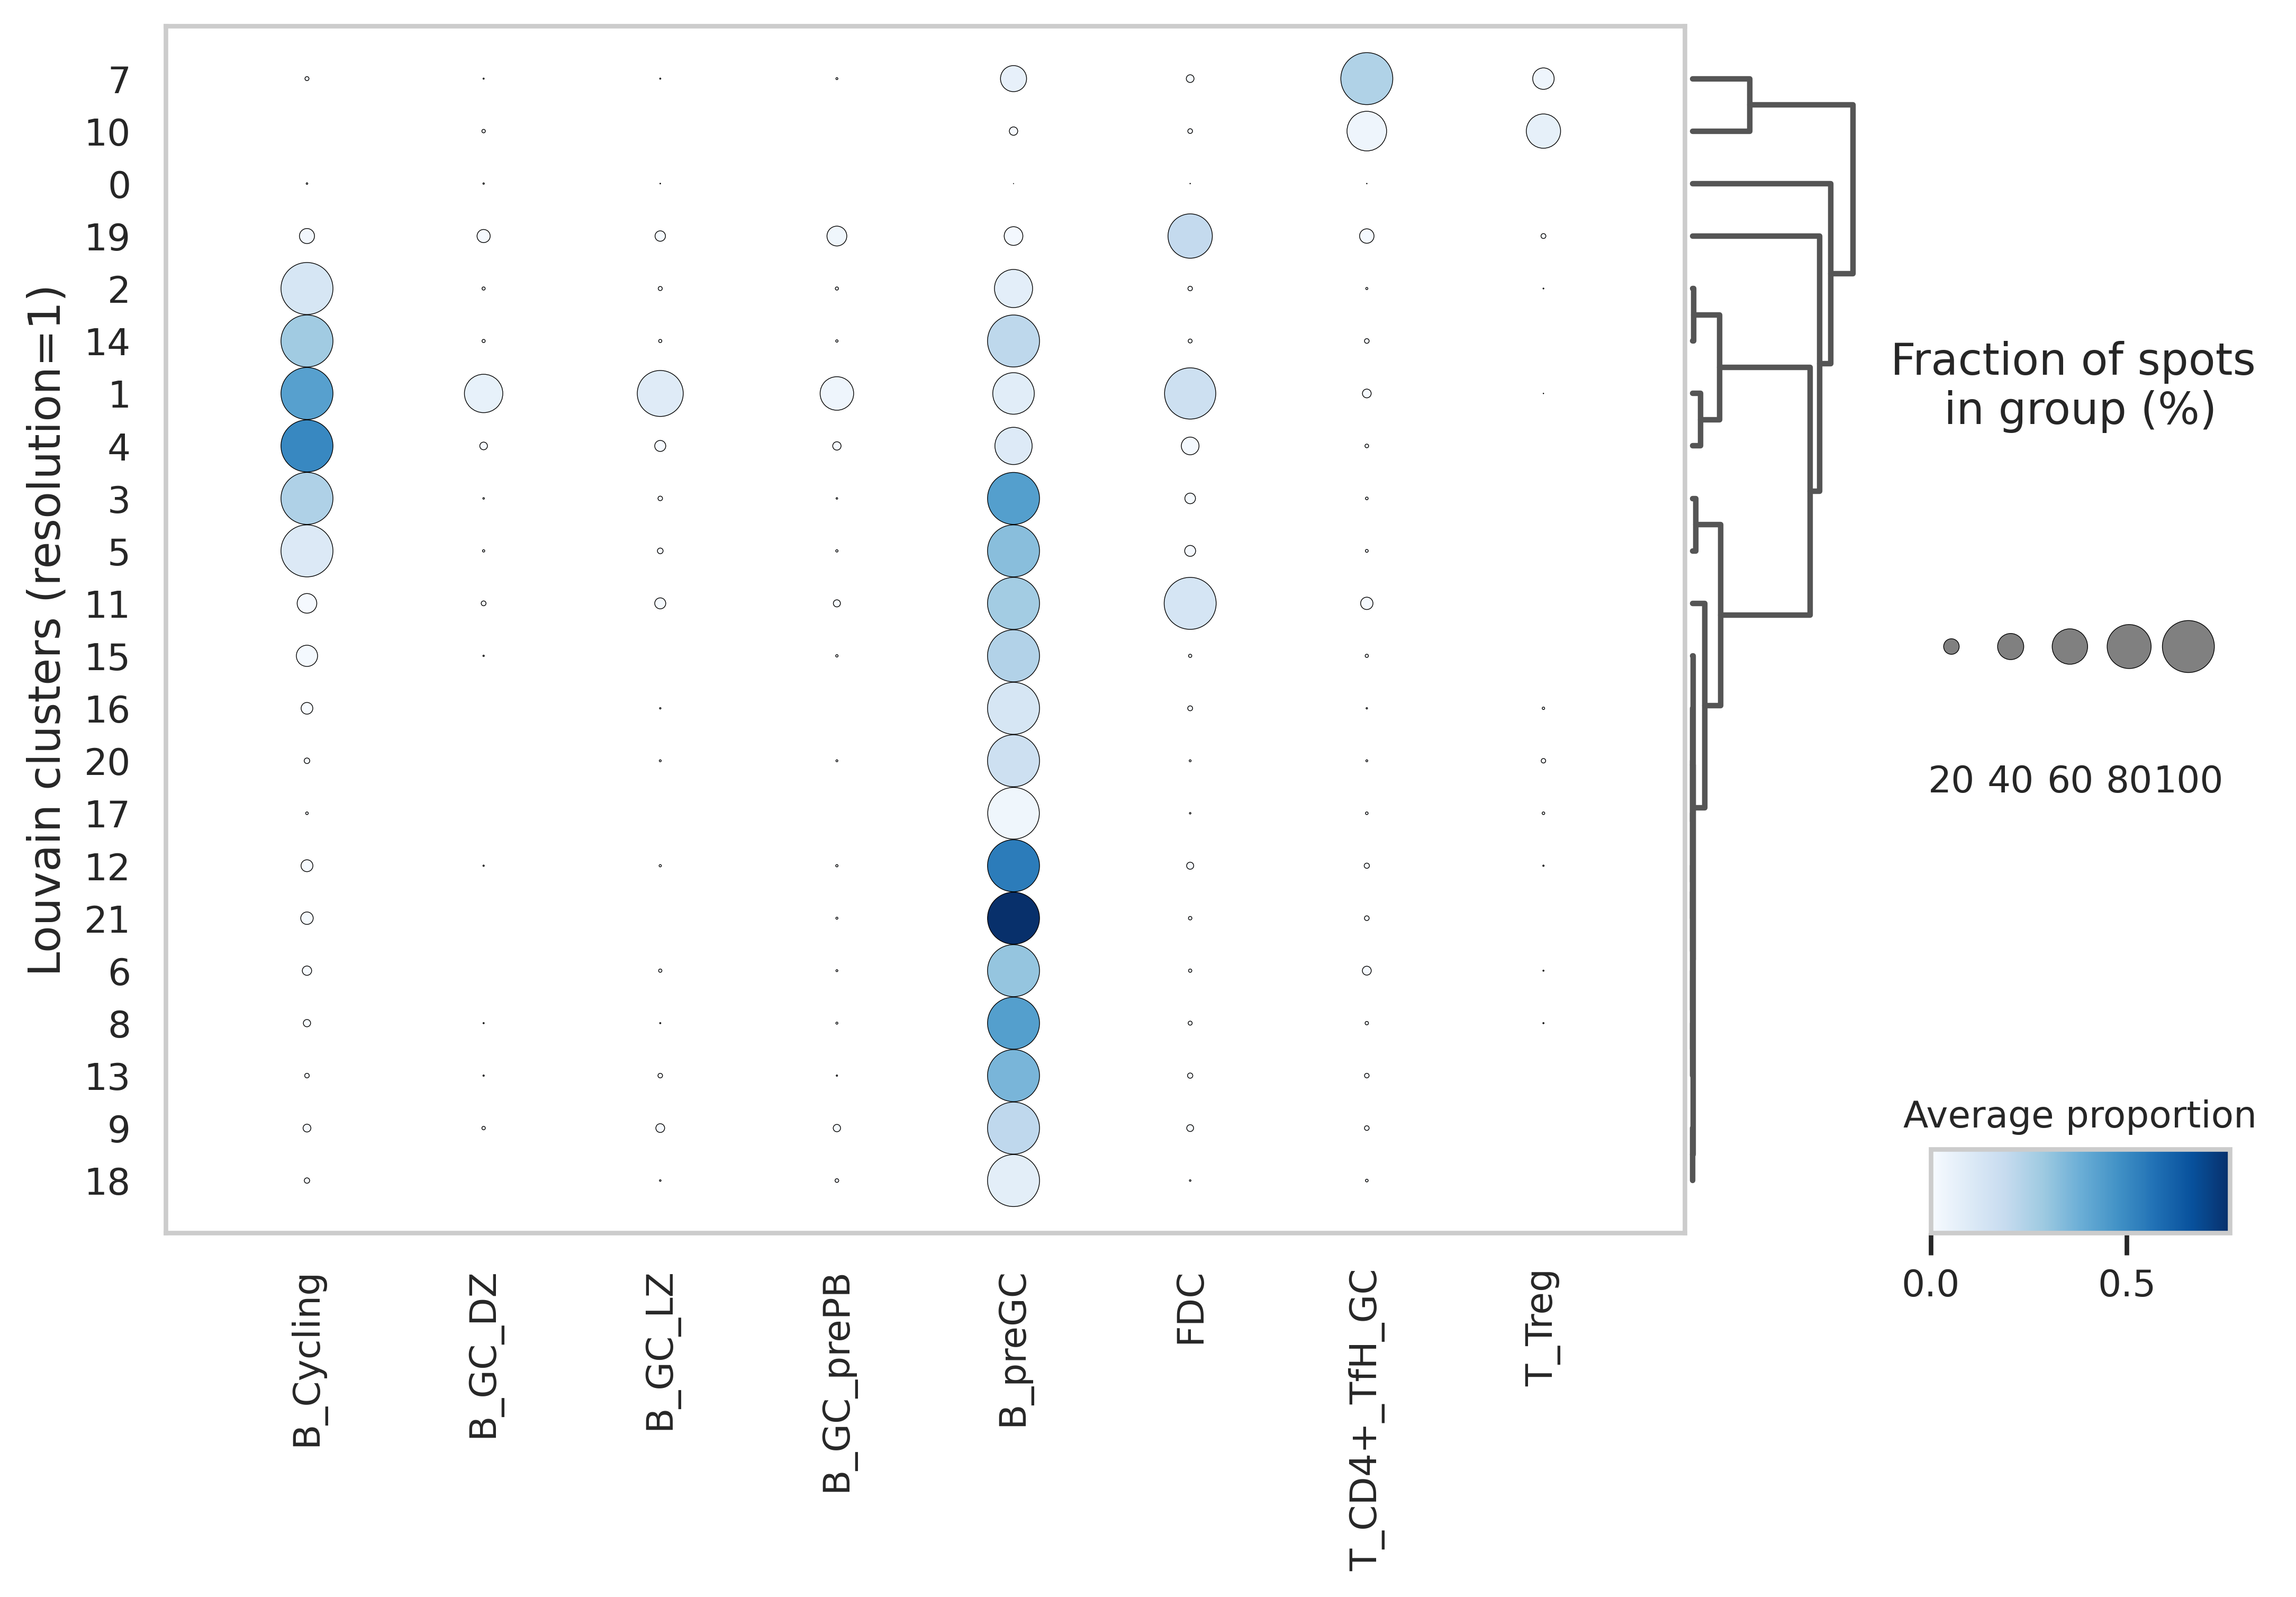

In [13]:
sns.set(style="whitegrid", font_scale=1)
g=sc.pl.dotplot(data_scores_tmp, var_names=data_scores_tmp.var_names, groupby="louvain",
             figsize=(10,6), swap_axes=False, cmap="Blues", colorbar_title="Average proportion",
             show=False, dendrogram=True, )
g["size_legend_ax"].set_title("Fraction of spots \nin group (%)")
g["mainplot_ax"].set_ylabel("Louvain clusters (resolution=1)")
plt.savefig("plots/clusters_lymph_node.png", bbox_inches="tight")

In [14]:
data_scores.obs["louvain"] = data_scores_tmp.obs["louvain"]

In [15]:
clsts = data_scores.obs.louvain.unique()
replace = []
for clst in clsts:
    if clst=="1" or clst=="4":
        replace.append(1)
    else:
        replace.append(0)
mapping = dict(zip(clsts, replace))

In [16]:
data_scores.obs.louvain.replace(mapping, inplace=True)
data_scores.obs["louvain"] = data_scores.obs.louvain.astype(float)

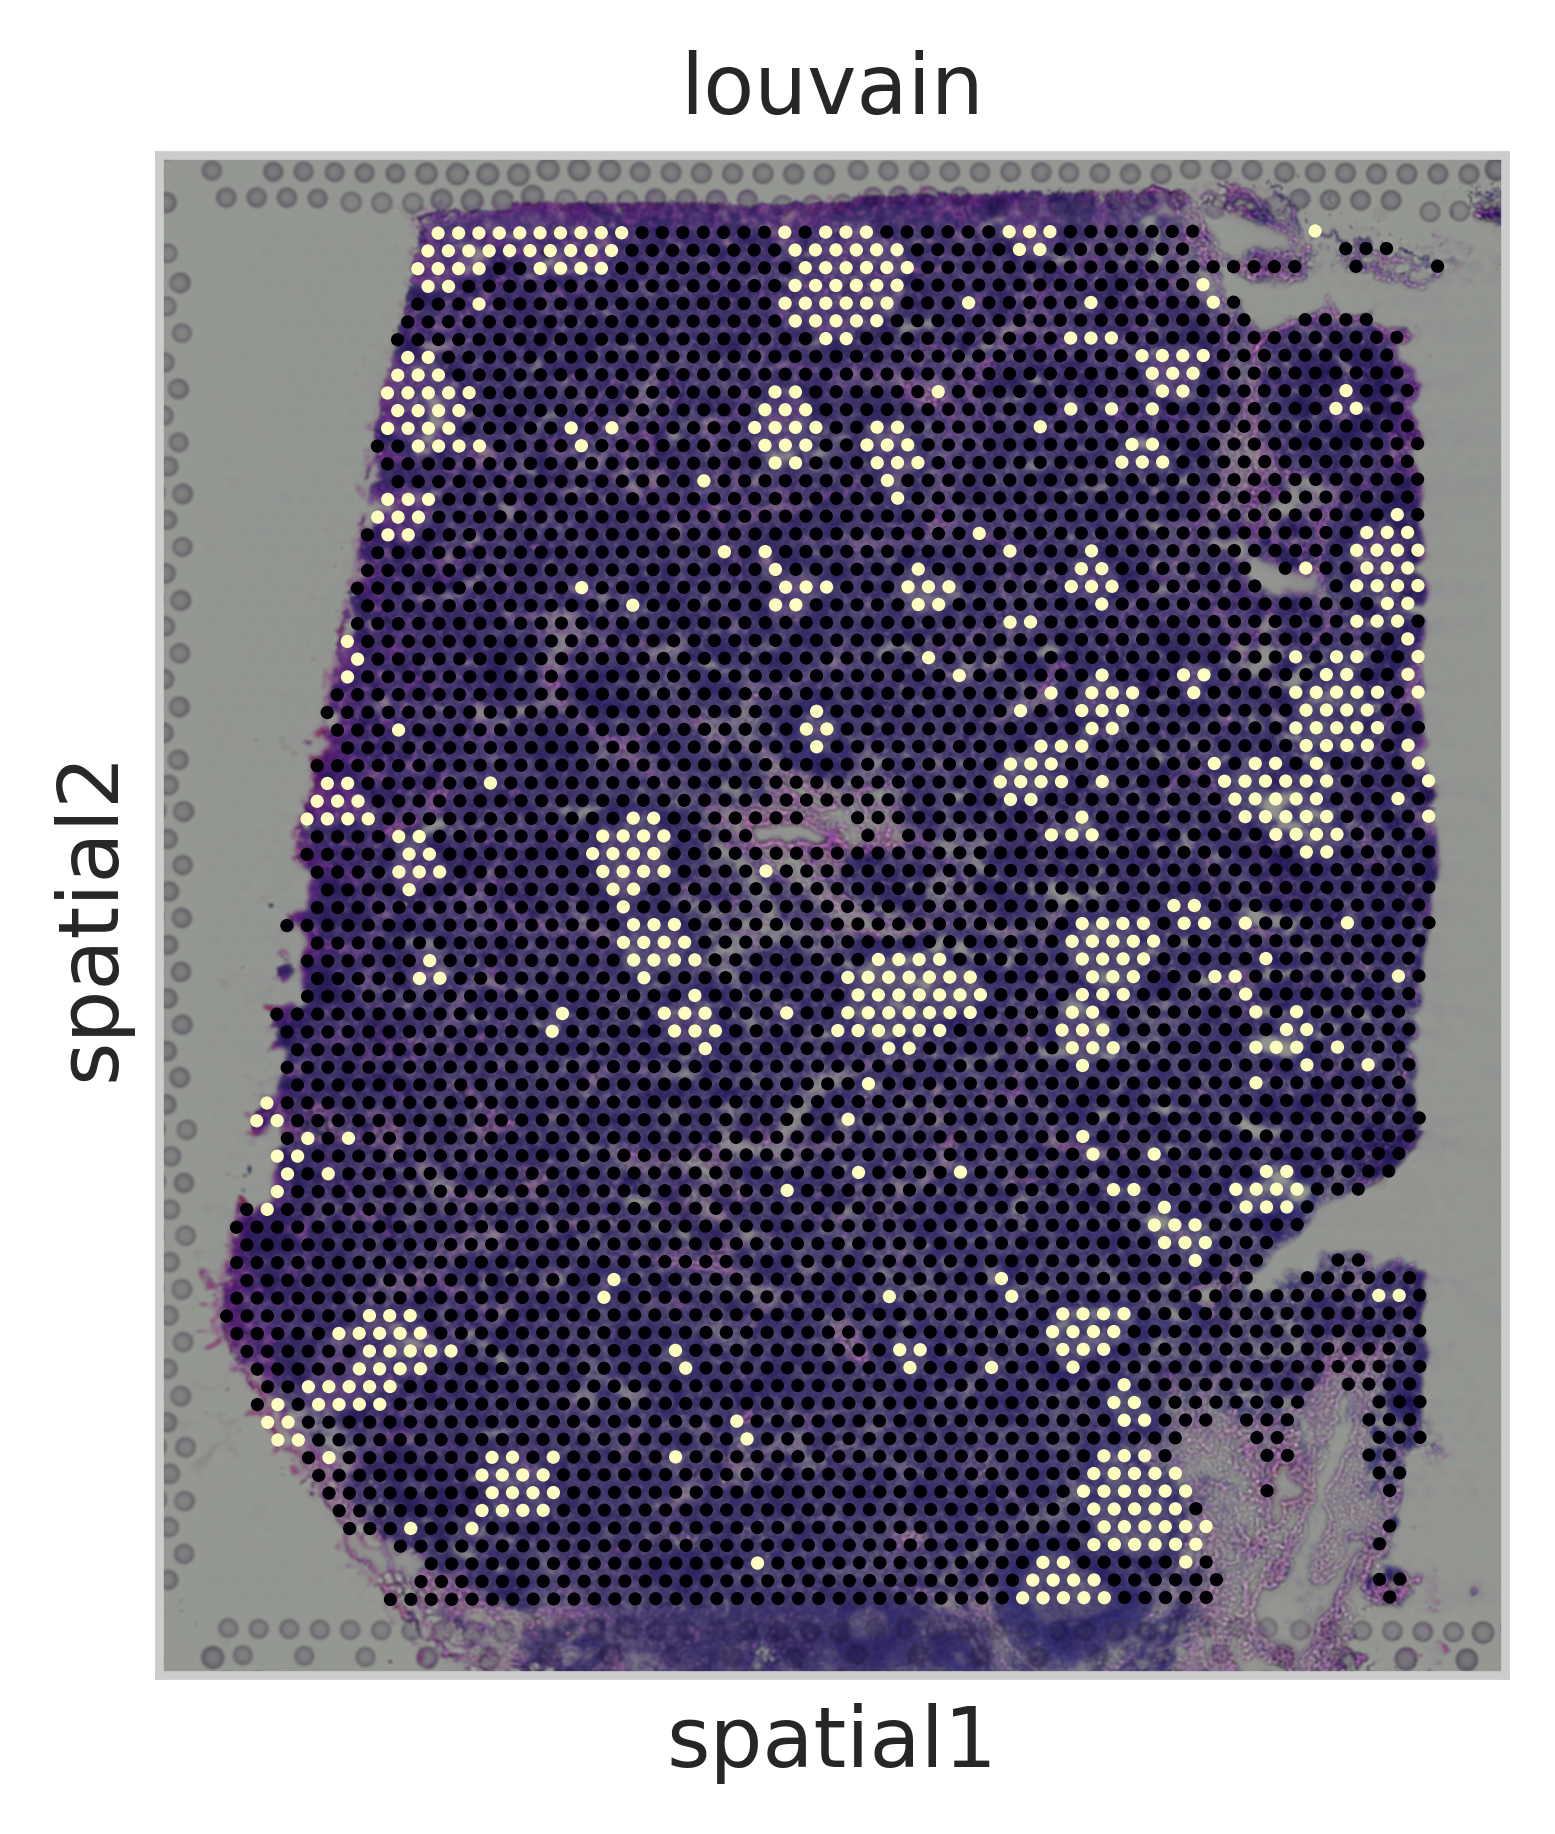

In [17]:
sc.pl.spatial(data_scores, color="louvain", cmap=cmap, colorbar_loc=None)

In [18]:
gcs = pd.read_csv("manual_GC_annot.csv", index_col=0)

In [19]:
data_scores.obs["true_GC"] = gcs.loc[data_scores.obs_names, "cell_type"].tolist()

In [20]:
t = data_scores.obs["true_GC"].tolist()
p = data_scores.obs["louvain"].astype(int).tolist()

In [21]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, confusion_matrix

<function matplotlib.pyplot.legend(*args, **kwargs)>

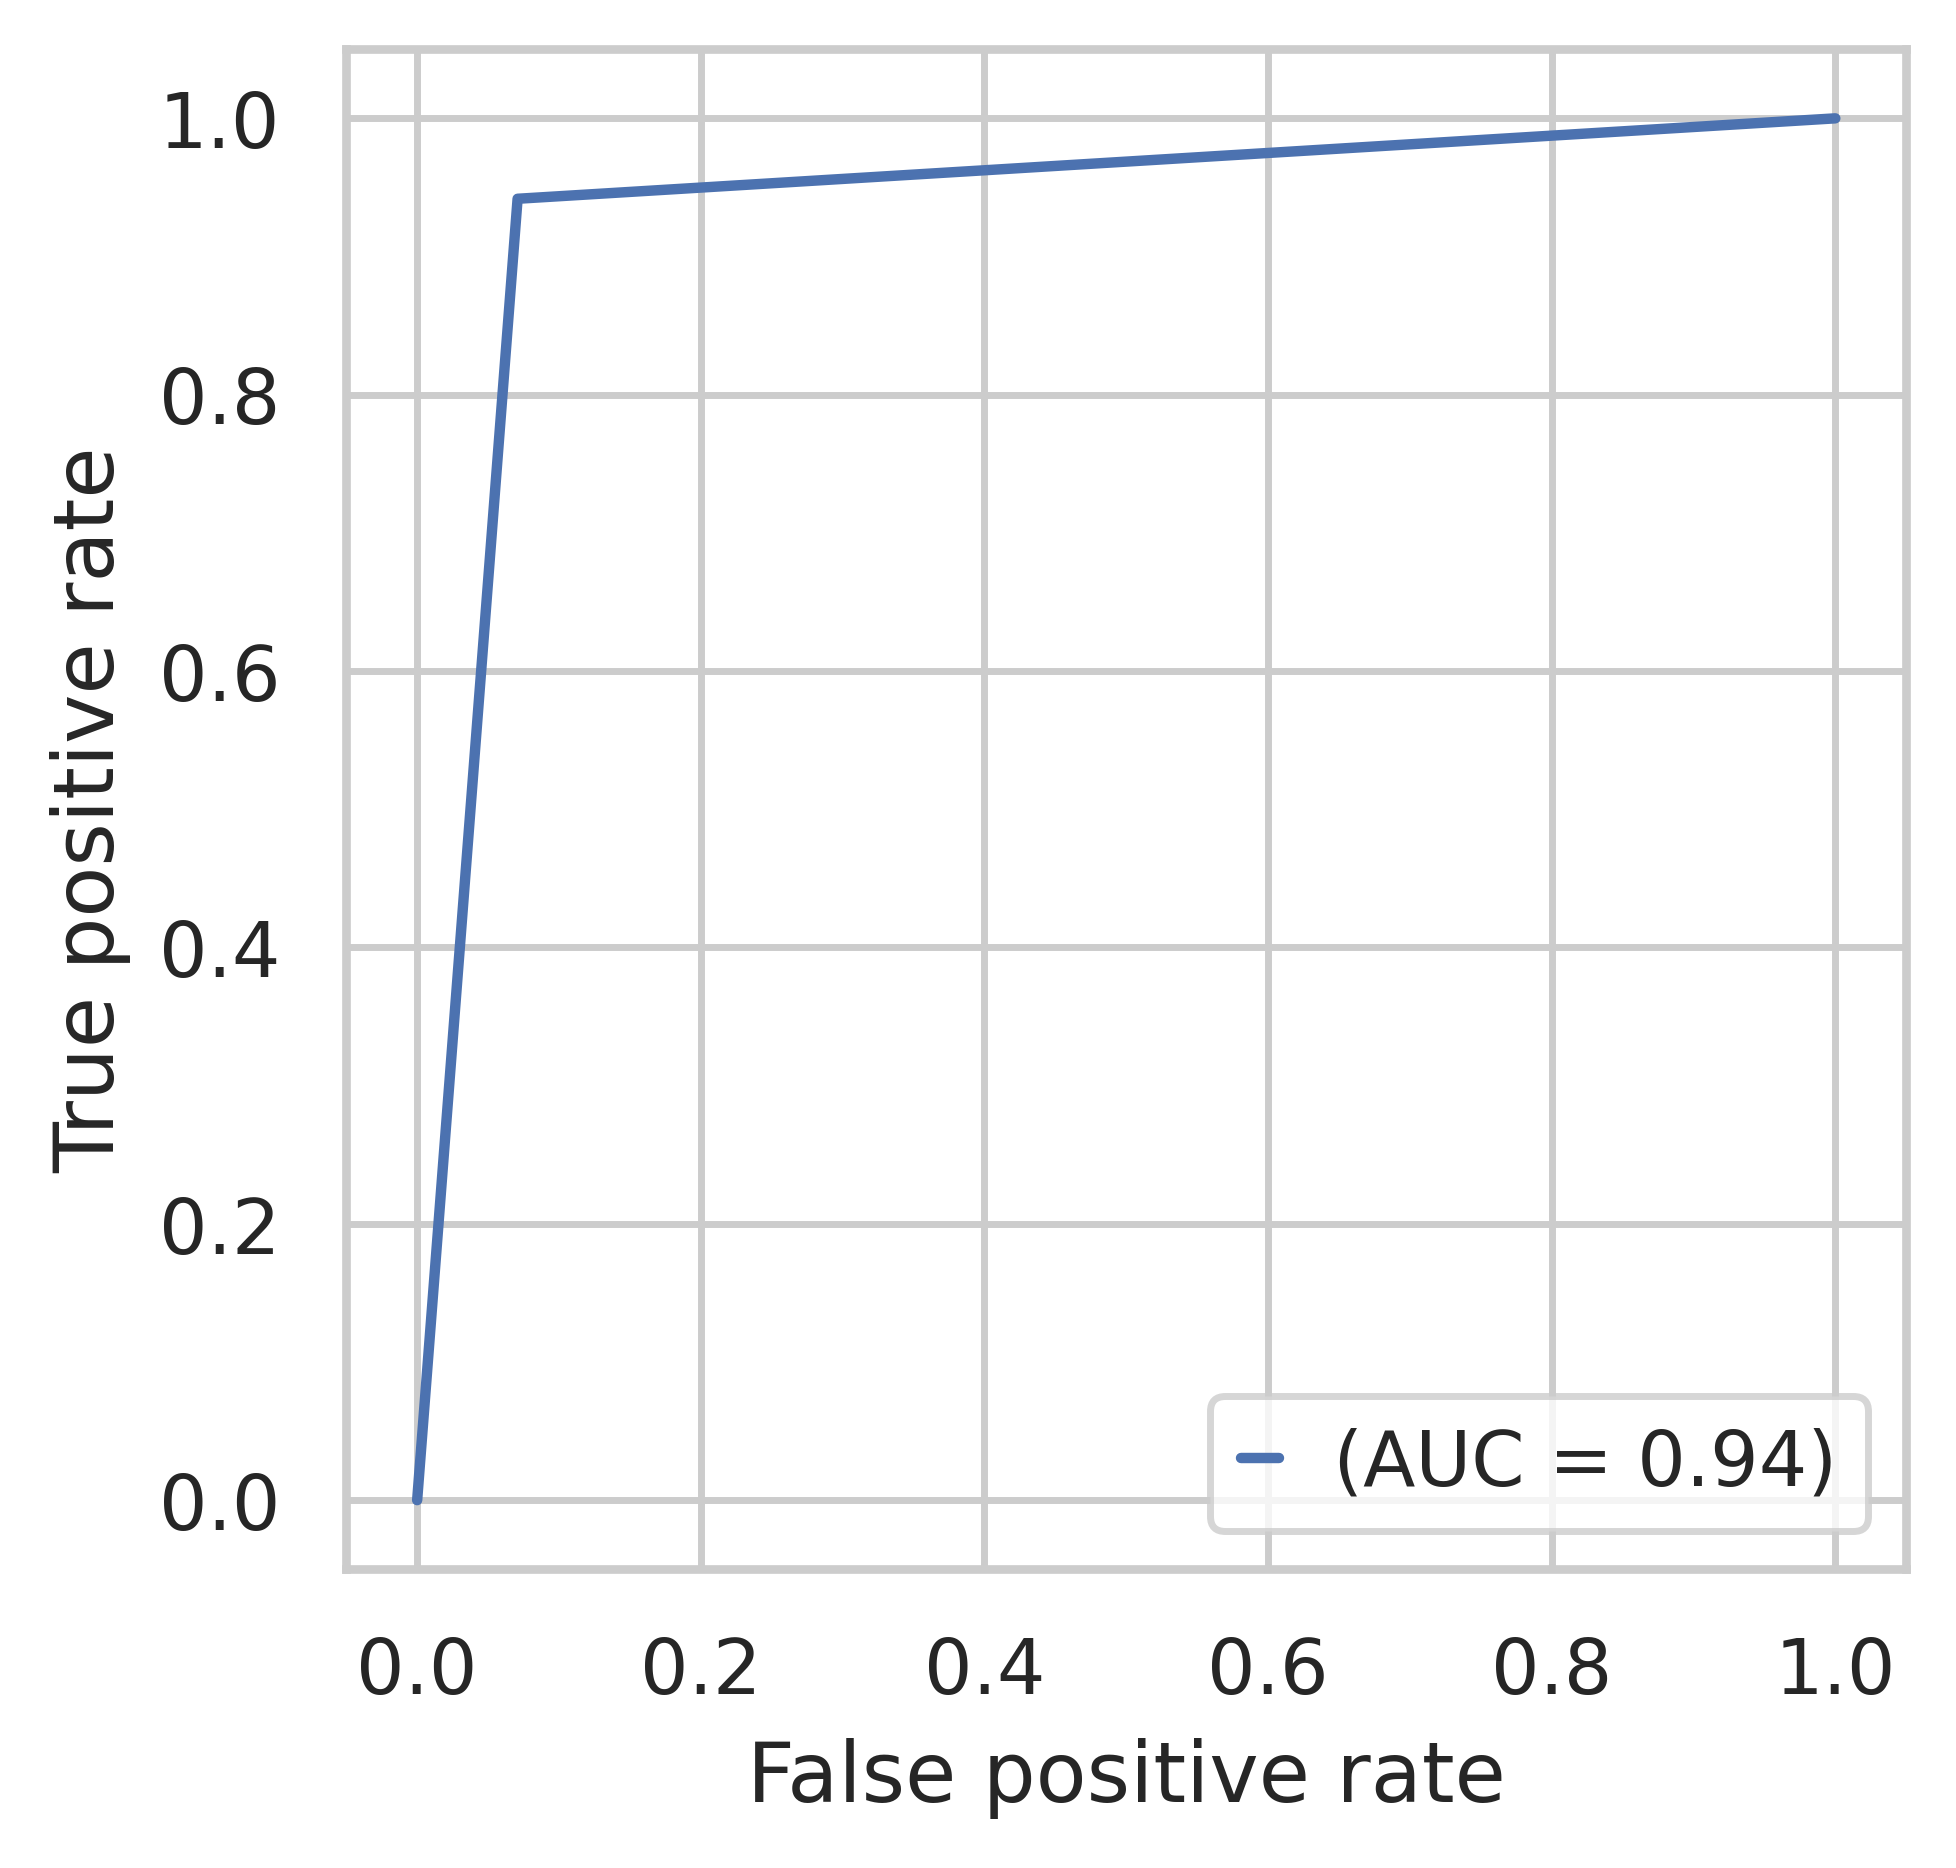

In [22]:
RocCurveDisplay.from_predictions(t, p, name="")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend

In [23]:
roc_auc_score(t,p)

0.9354879313862087

In [24]:
from sklearn.metrics import balanced_accuracy_score
mat = balanced_accuracy_score(t, p)

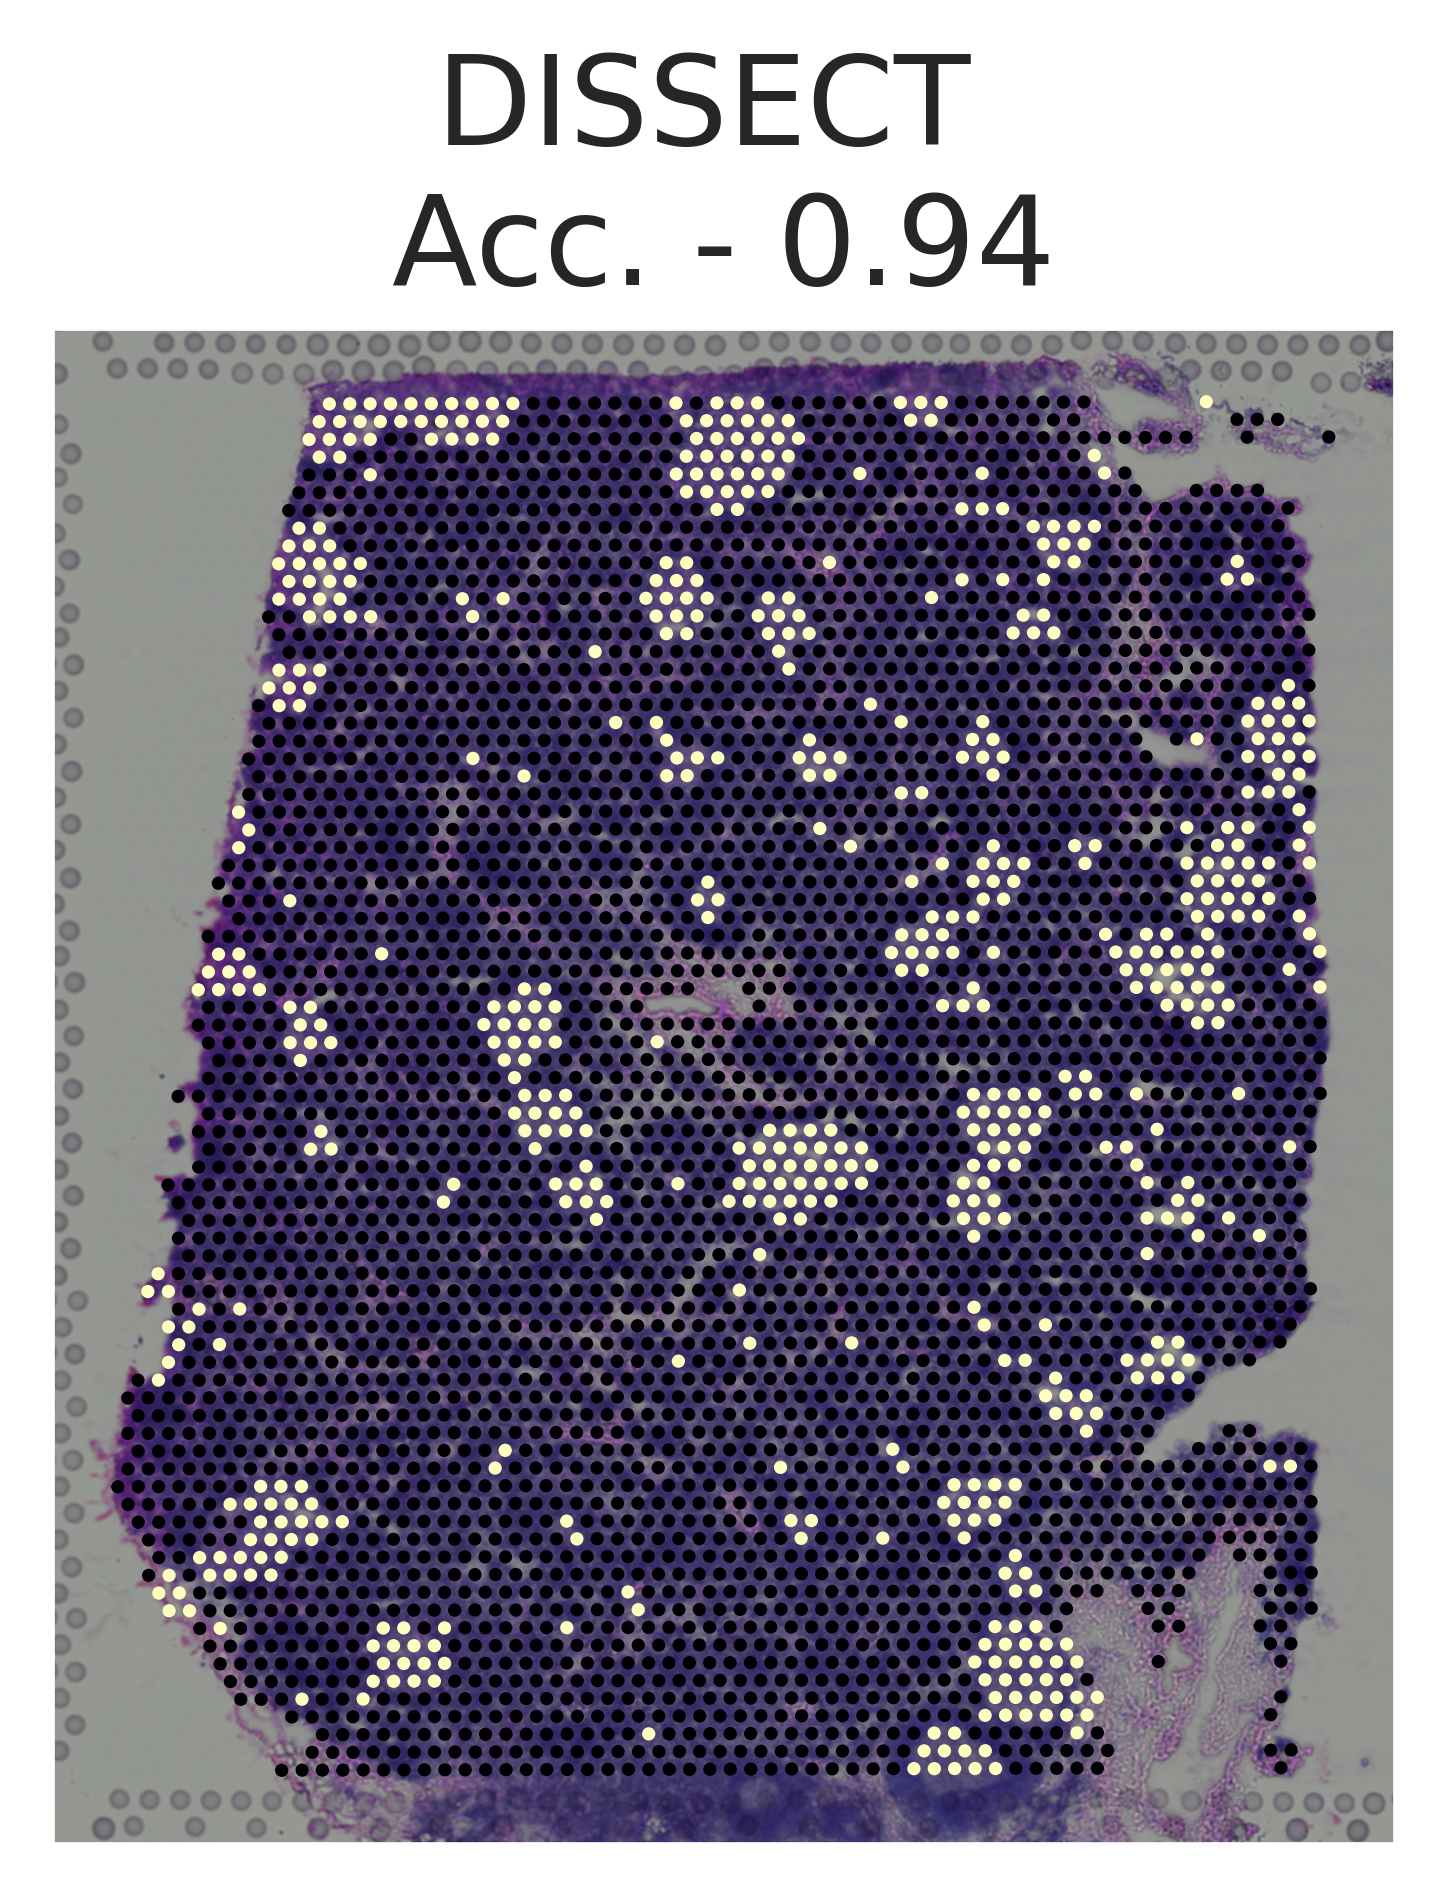

In [25]:
sc.set_figure_params(dpi=250)
sns.set(font_scale=1.5)

g=sc.pl.spatial(data_scores, color="louvain", cmap=cmap, colorbar_loc=None, title="DISSECT \nAcc. - {}".format(round(mat,2)), show=False)
g[0].set_ylabel("")
g[0].set_xlabel("")

plt.savefig("GC_predicted.png", bbox_inches="tight")

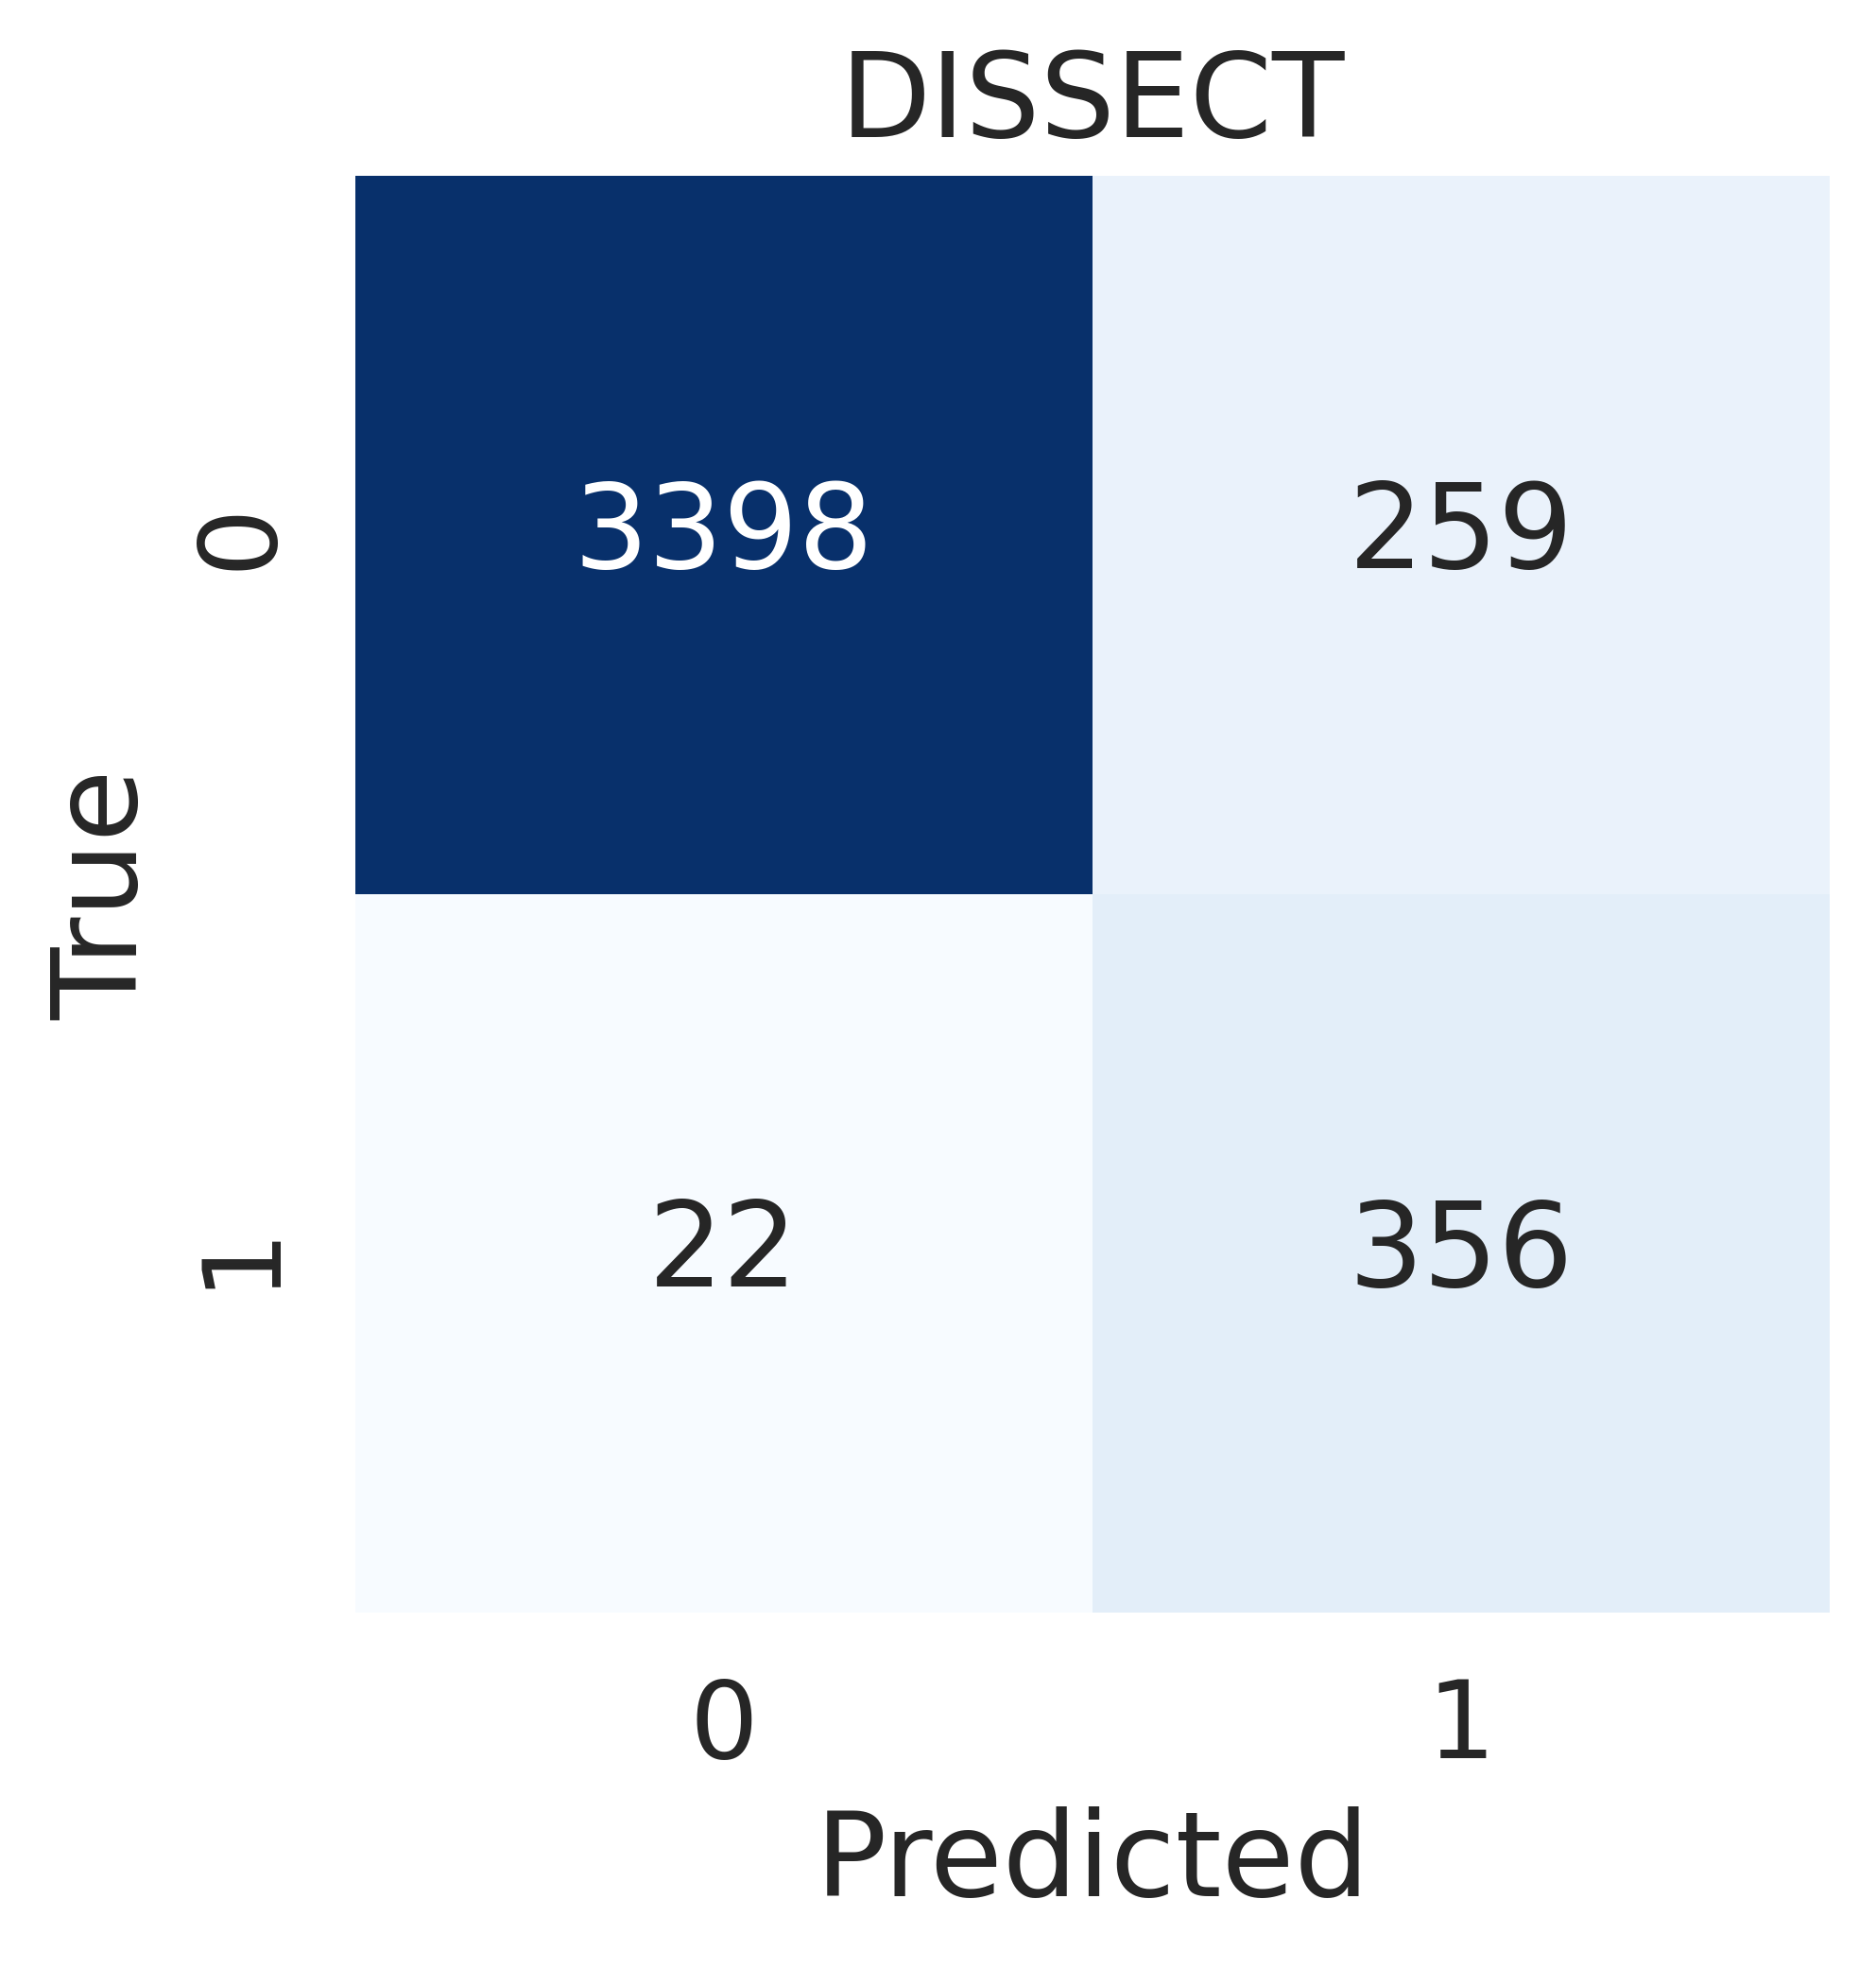

In [41]:
from sklearn.metrics import confusion_matrix
df= pd.DataFrame(confusion_matrix(t, p))
sns.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("DISSECT")
plt.savefig("cm.png", bbox_inches="tight", dpi=600)

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(t, p)

0.9303593556381661

In [29]:
pd.Series(t).value_counts()

0    3657
1     378
dtype: int64